In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pydot

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Pre-processing Data: #3

In [2]:
csectData = pd.read_csv('dataFiles/cSectionAprHospFeat.csv')
csectData.shape

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(215245, 68)

In [3]:
colsRemove = ['Length of Stay', #same as days
             'APR DRG Code', #all 540
             'APR DRG Description', #all c-sections
              'Efficient use of medical imaging national comparison', # too many NaNs
             'lonlat', #spatial 
             'geometry', #spatial
             'puma', #spatial
             'rural_versus_urban_R', #binary represented by rural_versus_urban_U
             'lat', #spatial
             'long', #spatial
             'Unnamed: 0', #extra index
             'Provider ID', #same as facility id
              'number_of_interns_and',
              'Total Costs', # related to charges
              'ratioChargesCosts',
              'chargesPerDay', 
              'ratioSumChargesPerFacPerYrToBedDays',
              'sumChargesPerFacIdPerYr'
             ]


csectData.drop(columns=colsRemove, inplace=True)
csectData.shape

(215245, 50)

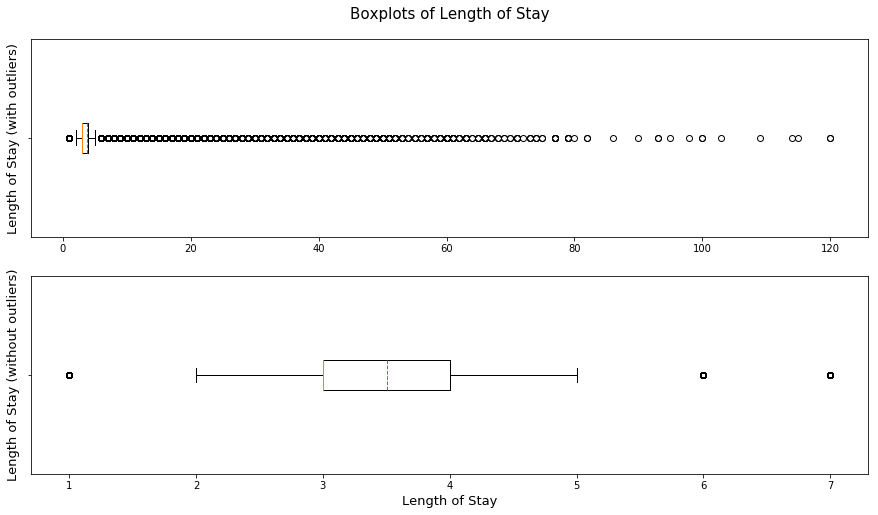

In [4]:
plt.figure(figsize=(15,8))

ax1 = plt.subplot(211)
ax1.boxplot(csectData['days'], vert=False, meanline=True, showmeans=True)
ax1.set_ylabel('Length of Stay (with outliers)', fontsize=13)
ax1.set_title('Boxplots of Length of Stay', fontsize=15, pad=20)
ax1.set_yticklabels([])

ax2 = plt.subplot(212)
ax2.boxplot(csectData[csectData['days'] <= 7]['days'], vert=False, meanline=True, showmeans=True)
ax2.set_ylabel('Length of Stay (without outliers)', fontsize=13)
ax2.set_xlabel('Length of Stay', fontsize=13)
ax2.set_yticklabels([])
plt.show()

We only keep data with days of stay less than or equal to seven (one week), losing 2.57% of the data.

In [5]:
csectData = csectData[csectData['days'] <= 7]

Drop all rows with NaNs. We are left with 81% of the data, which is still a large data set, plenty of rows for our analysis.

In [6]:
csectData.dropna(axis=0, inplace=True)
csectData.reset_index(inplace=True, drop=True)
csectData.shape

(206565, 50)

### Normalize Non-Discrete Features

In [7]:
cols_to_scale = ['fte_employees_on_payroll', 'number_of_beds',
                 'totalPopulation', 'totalInsured',
                 'countPerDrgPerFacIdPerYr', 'countPerFacIdPerYr',
                 'ratioDrgToFacility', 'numberOfPaymentTypes',
                 'numberUrgentAdmits', 'ratioInsuredTotalPopulation',
                 'days', 'avgNumberDays', 'Total Charges']

In [8]:
for cols in range(len(cols_to_scale)):
    csectData[str('scale_'+cols_to_scale[cols])] = scale(csectData[cols_to_scale[cols]])

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [9]:
csectData['Facility Id'] = csectData['Facility Id'].astype('int64')

In [10]:
# get dummies for facility ids and health service area
fidDummies = pd.get_dummies(csectData['Facility Id'], prefix='fid')
hsaDummies = pd.get_dummies(csectData['Health Service Area'], prefix='hsa')
dummies = [fidDummies, hsaDummies]
dummiesDf = pd.concat(dummies, axis=1)

In [11]:
print(fidDummies.shape)
print(hsaDummies.shape)
print(dummiesDf.shape)

(206565, 99)
(206565, 8)
(206565, 107)


In [12]:
csectData.drop(columns=['Facility Id', 'Health Service Area'], inplace=True)
csectData = csectData.merge(dummiesDf, left_index=True, right_index=True)
csectData.shape

(206565, 168)

In [13]:
csectDataLR = csectData.drop(columns=['fte_employees_on_payroll', 'number_of_beds',
                                      'totalPopulation', 'totalInsured',
                                      'countPerDrgPerFacIdPerYr', 'countPerFacIdPerYr',
                                      'ratioDrgToFacility', 'numberOfPaymentTypes',
                                      'numberUrgentAdmits', 'ratioInsuredTotalPopulation',
                                      'days', 'avgNumberDays', 'Total Charges'])
csectDataLR['intercept'] = 1
csectDataLR.shape

(206565, 156)

## Linear Regression Model

In [14]:
X = csectDataLR.drop(columns=['scale_Total Charges'])
y = csectDataLR['scale_Total Charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=13)

clf = LinearRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.7662479751649849
0.7638129886117714


In [52]:
# index of columns sorted in ascending order
coefColIndex = np.argsort(clf.coef_)

# features sorted by decreasing coefficients
regFeat = []
for i in coefColIndex:
    regFeat.append(X.columns[-i])

regFeat

['Type of Admission_Emergency',
 'fid_1318',
 'fid_218',
 'scale_numberOfPaymentTypes',
 'fid_925',
 'fid_541',
 'scale_ratioDrgToFacility',
 'Hospital overall rating',
 'scale_ratioInsuredTotalPopulation',
 'payment_Self-Pay',
 'Hospital Ownership_Government - Local',
 'payment_Department of Corrections',
 'fid_938',
 'fid_1',
 'Effectiveness of care national comparison',
 'fid_1129',
 'Type of Admission_Trauma',
 'fid_565',
 'fid_1294',
 'fid_411',
 'Hospital Ownership_Proprietary',
 'fid_393',
 'fid_727',
 'fid_135',
 'fid_804',
 'fid_1301',
 'fid_815',
 'rural_versus_urban_U',
 'fid_5',
 'Timeliness of care national comparison',
 'fid_866',
 'fid_98',
 'fid_704',
 'fid_484',
 'fid_636',
 'fid_43',
 'emergencyRoom',
 'hsa_Western NY',
 'fid_583',
 'payment_Managed Care, Unspecified',
 'fid_678',
 'fid_1454',
 'fid_552',
 'fid_977',
 'scale_fte_employees_on_payroll',
 'payment_Medicaid',
 'fid_1439',
 'fid_1463',
 'fid_367',
 'fid_699',
 'fid_409',
 'fid_339',
 'fid_1450',
 'payment_

##### Multivariate Linear Regression

##### statsmodels for the summary table

In [65]:
x_train = sm.add_constant(X_train)
model = sm.OLS(y_train, x_train)
results = model.fit()
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     scale_Total Charges   R-squared:                       0.766
Model:                             OLS   Adj. R-squared:                  0.766
Method:                  Least Squares   F-statistic:                     3809.
Date:                 Wed, 15 May 2019   Prob (F-statistic):               0.00
Time:                         19:15:31   Log-Likelihood:                -95695.
No. Observations:               138398   AIC:                         1.916e+05
Df Residuals:                   138278   BIC:                         1.928e+05
Df Model:                          119                                         
Covariance Type:             nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


#### Identify number of components to carry out PCA

In [66]:
scaler = MinMaxScaler(feature_range=[0, 1])
XRescaled = scaler.fit_transform(X.iloc[:,1:])

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


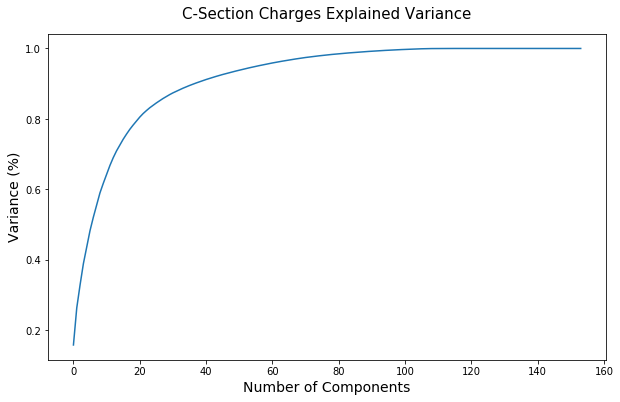

In [67]:
pca = PCA().fit(XRescaled)
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Variance (%)', fontsize=14) #for each component
plt.title('C-Section Charges Explained Variance', fontsize=15, pad=15)
plt.show()

Only need 80 components to explain 100% of variance, so we perform PCA with n_components=80.

In [68]:
pca = PCA(n_components=80)
XTransformed = pca.fit_transform(XRescaled)

Perform OLS Regression again with reduced dimensionality of features

In [69]:
XT_train, XT_test, y_train, y_test = train_test_split(XTransformed, y, test_size=0.33, random_state=13)

clfPCA = LinearRegression()
clfPCA.fit(XT_train, y_train)
y_pred_PCA = clfPCA.predict(XT_test)
print(clfPCA.score(XT_train, y_train))
print(clfPCA.score(XT_test, y_test))

0.7507182464347048
0.7489601599638183


OLS performance didn't improve! Boo! And no interpretability :(

## Random Forest Regressor

In [70]:
csectDataRF = csectData.drop(columns=['scale_fte_employees_on_payroll', 'scale_number_of_beds',
                                      'scale_totalPopulation', 'scale_totalInsured',
                                      'scale_countPerDrgPerFacIdPerYr', 'scale_countPerFacIdPerYr',
                                      'scale_ratioDrgToFacility', 'scale_numberOfPaymentTypes',
                                      'scale_numberUrgentAdmits', 'scale_ratioInsuredTotalPopulation',
                                      'scale_days', 'scale_avgNumberDays', 'scale_Total Charges'])
csectDataRF.shape

(206565, 155)

In [71]:
X = csectDataRF.drop(columns=['Total Charges'])
y = csectDataRF['Total Charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=13)

### Hyperparameter Tuning: max_depth

In [72]:
max_depth = [5, 10, 15, 20, 25, 30, 35, 40]
depthTestScores = []
depthTrainScores = []
depthOOBScores = []

for n in max_depth:
    rf = RandomForestRegressor(n_estimators=100, max_depth=n, random_state=13, oob_score=True)
    rf.fit(X_train, y_train)
    depthTrainScores.append(rf.score(X_train, y_train))
    depthTestScores.append(rf.score(X_test, y_test))
    depthOOBScores.append(rf.oob_score_)

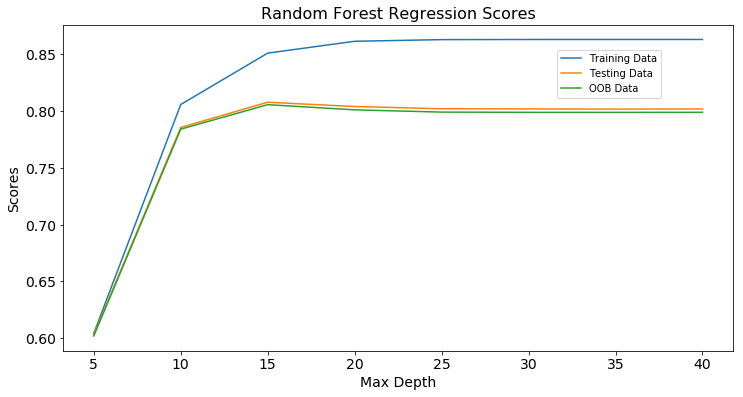

In [73]:
plt.figure(figsize=(12,6))
plt.title('Random Forest Regression Scores', fontsize=16)
plt.plot(max_depth, depthTrainScores, label='Training Data')
plt.plot(max_depth, depthTestScores, label='Testing Data')
plt.plot(max_depth, depthOOBScores, label='OOB Data')
plt.xticks(fontsize=14)
plt.xlabel('Max Depth', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.legend(bbox_to_anchor=(0.9, 0.85))
plt.show()

Choose max_depth=15 as parameter.

### Hyperparameter Tuning: n_estimators

In [74]:
n_estimators = [1, 10, 20, 50, 70, 100, 120, 150]
nTestScores = []
nTrainScores = []
nOOBScores = []

for n in n_estimators:
    rf = RandomForestRegressor(n_estimators=n, random_state=13, max_depth=15, oob_score=True)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    nTrainScores.append(rf.score(X_train, y_train))
    nTestScores.append(rf.score(X_test, y_test))
    nOOBScores.append(rf.oob_score_)

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


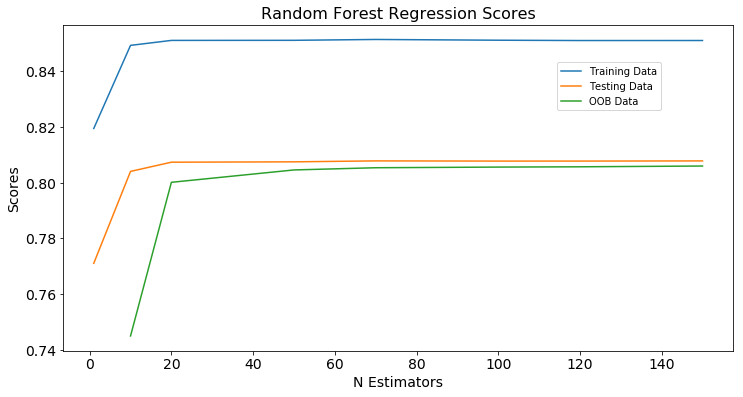

In [75]:
plt.figure(figsize=(12,6))
plt.title('Random Forest Regression Scores', fontsize=16)
plt.plot(n_estimators, nTrainScores, label='Training Data')
plt.plot(n_estimators, nTestScores, label='Testing Data')
plt.plot(n_estimators[1:], nOOBScores[1:], label='OOB Data')
plt.xticks(fontsize=14)
plt.xlabel('N Estimators', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.legend(bbox_to_anchor=(0.9,0.9))
plt.show()

Choose n_estimators = 50.

### RFR Model 1: n_estimators=50 and max_depth=15

In [76]:
rf = RandomForestRegressor(n_estimators=50, max_depth=15, random_state=13, oob_score=True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(rf.score(X_train, y_train))
print(rf.oob_score_)
print(rf.score(X_test, y_test))

0.8508578831431804
0.8044926847049801
0.8073898587340842


#### RFR Model 1: Feature Importance

In [77]:
importances = list(rf.feature_importances_)
rfFeatImpt = [(feature, round(importance, 2)) for feature, importance in zip(list(X.columns), importances)]
rfFeatImpt = sorted(rfFeatImpt, key = lambda x: x[1], reverse = True)
for pair in rfFeatImpt:
    print('Variable: {:65} Importance: {}'.format(*pair))

Variable: fte_employees_on_payroll                                          Importance: 0.2
Variable: days                                                              Importance: 0.18
Variable: countPerDrgPerFacIdPerYr                                          Importance: 0.12
Variable: avgNumberDays                                                     Importance: 0.1
Variable: totalInsured                                                      Importance: 0.03
Variable: totalFertile                                                      Importance: 0.03
Variable: ratioDrgToFacility                                                Importance: 0.03
Variable: Hospital Ownership_Government - Hospital District or Authority    Importance: 0.03
Variable: ratioFertilityTotalPopulation                                     Importance: 0.03
Variable: fid_1139                                                          Importance: 0.03
Variable: APR Severity of Illness Code                                  

### RFR Model 2: n_estimators=50, max_depth=15 and bootstrap=True

In [78]:
rf2 = RandomForestRegressor(n_estimators=50, random_state=13, max_depth=15, oob_score=True, bootstrap=True)
rf2.fit(X_train, y_train)
y_pred = rf2.predict(X_test)

print(rf2.score(X_train, y_train))
print(rf2.oob_score_)
print(rf2.score(X_test, y_test))

0.8508578831431804
0.8044926847049801
0.8073898587340842


#### RFR Model 2: Feature Importance

In [79]:
importances = list(rf2.feature_importances_)
rf2FeatImpt = [(feature, round(importance, 2)) for feature, importance in zip(list(X.columns), importances)]
rf2FeatImpt = sorted(rf2FeatImpt, key = lambda x: x[1], reverse = True)
for pair in rf2FeatImpt:
    print('Variable: {:65} Importance: {}'.format(*pair))

Variable: fte_employees_on_payroll                                          Importance: 0.2
Variable: days                                                              Importance: 0.18
Variable: countPerDrgPerFacIdPerYr                                          Importance: 0.12
Variable: avgNumberDays                                                     Importance: 0.1
Variable: totalInsured                                                      Importance: 0.03
Variable: totalFertile                                                      Importance: 0.03
Variable: ratioDrgToFacility                                                Importance: 0.03
Variable: Hospital Ownership_Government - Hospital District or Authority    Importance: 0.03
Variable: ratioFertilityTotalPopulation                                     Importance: 0.03
Variable: fid_1139                                                          Importance: 0.03
Variable: APR Severity of Illness Code                                  

## RF Model 3: remove features with 0 importance

In [80]:
unimptFeat = []

for pair in rf2FeatImpt:
    if pair[1] == 0:
        unimptFeat.append(pair[0])
        
unimptFeat.append('Total Charges')

In [81]:
X = csectDataRF.drop(columns=unimptFeat)
y = csectDataRF['Total Charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=13)

In [82]:
rf3 = RandomForestRegressor(n_estimators=50, random_state=13, max_depth=15, oob_score=True, bootstrap=True)
rf3.fit(X_train, y_train)
y_pred = rf3.predict(X_test)

print(rf3.score(X_train, y_train))
print(rf3.oob_score_)
print(rf3.score(X_test, y_test))

0.8366956961928989
0.8103900217926646
0.8116115112544682


In [83]:
importances = list(rf3.feature_importances_)
rf3FeatImpt = [(feature, round(importance, 2)) for feature, importance in zip(list(X.columns), importances)]
rf3FeatImpt = sorted(rf3FeatImpt, key = lambda x: x[1], reverse = True)
for pair in rf3FeatImpt:
    print('Variable: {:65} Importance: {}'.format(*pair))

Variable: fte_employees_on_payroll                                          Importance: 0.2
Variable: days                                                              Importance: 0.18
Variable: countPerDrgPerFacIdPerYr                                          Importance: 0.13
Variable: avgNumberDays                                                     Importance: 0.11
Variable: ratioFertilityTotalPopulation                                     Importance: 0.04
Variable: fid_1139                                                          Importance: 0.04
Variable: number_of_beds                                                    Importance: 0.03
Variable: totalInsured                                                      Importance: 0.03
Variable: totalFertile                                                      Importance: 0.03
Variable: ratioDrgToFacility                                                Importance: 0.03
Variable: Hospital Ownership_Government - Hospital District or Authorit

In [84]:
tree = rf3.estimators_[13]
export_graphviz(tree, out_file = 'rf3tree.dot', feature_names = list(X.columns), rounded = True, precision = 1)

## RF Model 4: Optimize max_depth and n_estimators

In [85]:
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
depthTestScoresNew = []
depthTrainScoresNew = []
depthOOBScoresNew = []

for n in max_depth:
    rf = RandomForestRegressor(n_estimators=50, max_depth=n, random_state=13, oob_score=True)
    rf.fit(X_train, y_train)
    depthTrainScoresNew.append(rf.score(X_train, y_train))
    depthTestScoresNew.append(rf.score(X_test, y_test))
    depthOOBScoresNew.append(rf.oob_score_)

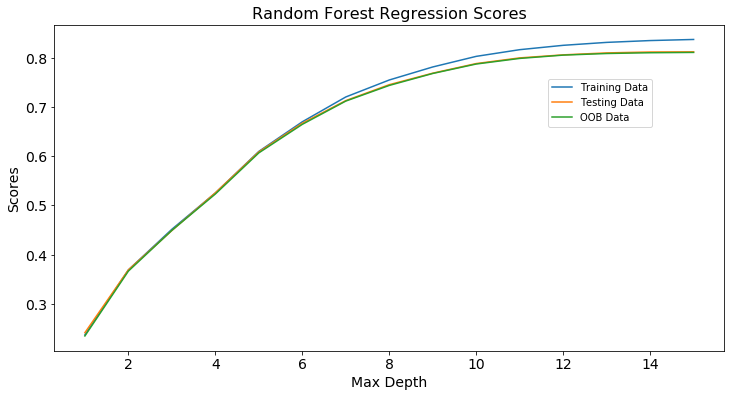

In [86]:
plt.figure(figsize=(12,6))
plt.title('Random Forest Regression Scores', fontsize=16)
plt.plot(max_depth, depthTrainScoresNew, label='Training Data')
plt.plot(max_depth, depthTestScoresNew, label='Testing Data')
plt.plot(max_depth, depthOOBScoresNew, label='OOB Data')
plt.xticks(fontsize=14)
plt.xlabel('Max Depth', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.legend(bbox_to_anchor=(0.9, 0.85))
plt.show()

In [87]:
n_estimators = [1, 10, 20, 50, 70, 100, 120, 150]
nTestScoresNew = []
nTrainScoresNew = []
nOOBScoresNew = []

for n in n_estimators:
    rf = RandomForestRegressor(n_estimators=n, random_state=13, max_depth=12, oob_score=True)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    nTrainScoresNew.append(rf.score(X_train, y_train))
    nTestScoresNew.append(rf.score(X_test, y_test))
    nOOBScoresNew.append(rf.oob_score_)

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


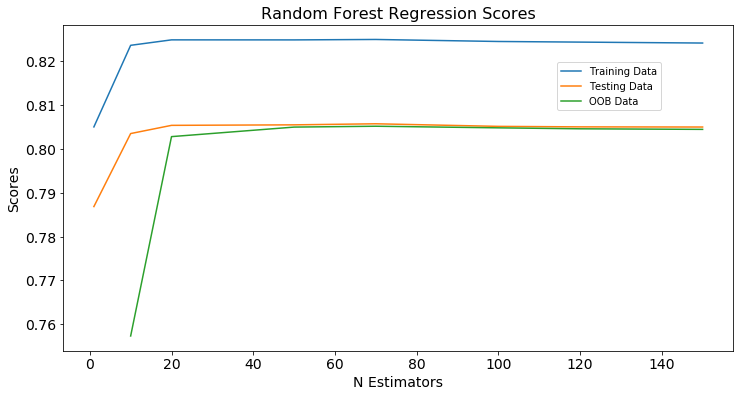

In [88]:
plt.figure(figsize=(12,6))
plt.title('Random Forest Regression Scores', fontsize=16)
plt.plot(n_estimators, nTrainScoresNew, label='Training Data')
plt.plot(n_estimators, nTestScoresNew, label='Testing Data')
plt.plot(n_estimators[1:], nOOBScoresNew[1:], label='OOB Data')
plt.xticks(fontsize=14)
plt.xlabel('N Estimators', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.legend(bbox_to_anchor=(0.9,0.9))
plt.show()

In [89]:
rf4 = RandomForestRegressor(n_estimators=30, random_state=13, max_depth=12, oob_score=True, bootstrap=True)
rf4.fit(X_train, y_train)
y_pred = rf4.predict(X_test)

print(rf4.score(X_train, y_train))
print(rf4.oob_score_)
print(rf4.score(X_test, y_test))

0.8245834704996371
0.8035272168565282
0.805015868067305


In [90]:
importances = list(rf4.feature_importances_)
rf4FeatImpt = [(feature, round(importance, 2)) for feature, importance in zip(list(X.columns), importances)]
rf4FeatImpt = sorted(rf4FeatImpt, key = lambda x: x[1], reverse = True)
for pair in rf4FeatImpt:
    print('Variable: {:65} Importance: {}'.format(*pair))

Variable: fte_employees_on_payroll                                          Importance: 0.21
Variable: days                                                              Importance: 0.18
Variable: countPerDrgPerFacIdPerYr                                          Importance: 0.13
Variable: avgNumberDays                                                     Importance: 0.11
Variable: ratioFertilityTotalPopulation                                     Importance: 0.04
Variable: fid_1139                                                          Importance: 0.04
Variable: totalInsured                                                      Importance: 0.03
Variable: totalFertile                                                      Importance: 0.03
Variable: ratioDrgToFacility                                                Importance: 0.03
Variable: APR Severity of Illness Code                                      Importance: 0.02
Variable: yr                                                          

#### For Conclusion

In [91]:
csectData.shape

(206565, 168)

In [92]:
hospPrices = pd.read_csv('dataFiles/compiledMasterchargesNycHospitals.csv')

In [93]:
hospPrices.drop(['Unnamed: 0'], axis=1, inplace=True)

In [94]:
hospPrices.head()

,hospitalName,drgType,facId,providerId,hospDrg,description,charges
0,BRONX-LEBANON HOSPITAL CENTER,APR-DRG,1164,330009,775.0,ALCOHOL ABUSE & DEPENDENCE,22066.805466
1,BRONX-LEBANON HOSPITAL CENTER,APR-DRG,1164,330009,772.0,ALCOHOL/DRUG DEP W/REHAB DETOX,29814.074395
2,BRONX-LEBANON HOSPITAL CENTER,APR-DRG,1164,330009,198.0,ANGINA PECTORIS & CORON ATHERO,21846.361053
3,BRONX-LEBANON HOSPITAL CENTER,APR-DRG,1164,330009,141.0,ASTHMA,9181.951122
4,BRONX-LEBANON HOSPITAL CENTER,APR-DRG,1164,330009,753.0,BIPOLAR DISORDERS,44274.231067


In [95]:
hospPrices = hospPrices[(hospPrices['drgType'] == 'APR-DRG') & 
                       (hospPrices['hospDrg'].isin([540.0]))]

In [96]:
hospPrices['facId'].unique()

array([1164, 1294, 1626, 1445, 1165, 1301, 1172, 1454, 1186, 1692])

In [97]:
hospPrices.shape

(10, 7)

In [98]:
fac_cols = ['fid_1294',  'fid_1445',
            'fid_1165', 'fid_1301',  'fid_1172', 
            'fid_1454', 'fid_1692', 'fid_1626']

In [99]:
fac_num = [1294, 1445, 1165, 1301, 1172, 1454, 1692, 1626]

##### Comparing Prices

In [100]:
csectDataRF.head()

,APR Severity of Illness Code,Total Charges,yr,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,...,fid_1738,fid_1740,hsa_Capital/Adiron,hsa_Central NY,hsa_Finger Lakes,hsa_Hudson Valley,hsa_Long Island,hsa_New York City,hsa_Southern Tier,hsa_Western NY
0,1.0,5977.61,2013,2.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,6946.11,2013,2.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,3.0,5300.26,2013,2.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,1.0,5390.61,2013,2.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,7988.61,2013,2.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [101]:
for i in range(len(fac_cols)):
    print('\n')
    print(fac_cols[i])
    facTemp = pd.DataFrame(csectDataRF[(csectDataRF[fac_cols[i]] == 1) & (csectDataRF['yr'] == 2016)].mean().drop(['Total Charges'])).T
    print('Predicted Value is ', rf2.predict(facTemp))
    print('Published Value is ', hospPrices[(hospPrices['facId'] == fac_num[i])]['charges'].iloc[0])



fid_1294
Predicted Value is  [21808.7470294]
Published Value is  18145.67


fid_1445
Predicted Value is  [17394.7749528]
Published Value is  18145.67


fid_1165
Predicted Value is  [17963.54731403]
Published Value is  18145.67


fid_1301
Predicted Value is  [18096.00148473]
Published Value is  18145.67


fid_1172
Predicted Value is  [21278.37694915]
Published Value is  18145.67


fid_1454
Predicted Value is  [21552.65777966]
Published Value is  18145.67


fid_1692
Predicted Value is  [18213.27338846]
Published Value is  18145.67


fid_1626
Predicted Value is  [19912.48806147]
Published Value is  18145.67
